# DS3000 Day 16

Nov 25/26, 2024

Admin
- Thanksgiving Break!
- Project Deadlines:
  - Mandatory Meeting with TA **by Dec. 5**
  - Project Report and Presentation due **Dec. 9 by 11:59 pm**
  - Statement of Contributions Google Form (link posted soon) due **Dec. 9 by 11:59 pm**
- Please fill out TRACE and, if possible, [this short form](https://forms.gle/EZFgKFQ7GyDTXQQJ9)!

Push-Up Tracker
- Section 03: 9
- Section 05: 10

Content:
- Principal Component Analysis

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import math
from sklearn.decomposition import PCA

## Today: A Little Unsupervised Learning

Recall that there are two main types of machine learning:

- Supervised: where the goal is to predict a feature
  - Regression (predicting a numeric value) and Classification (predicting a categorical label) have been our focus
- Unsupervised: where the goal is to understand the structure of the data

There are many varied unsupervised algorithms that are used for various things:

- Markov Chains for characterizing the dynamics of a system
- Clustering algorithms (e.g. K-means) for grouping data
- Likelihood and Kernel Estimation for understanding the distribution of features
- **Dimensionality Reduction** for making computation more efficient

Since **Principal Component Analysis** is a very popular dimensionality reduction technique which uses a lot of the tools we've already learned, we will start there. If there is still time afterwards, we may also look into Markov Chains!

### Some Motivation

Imagine you want to do regression, but your data set has many fewer observations than it has features. E.g. you want to predict $y$ with $X$ below:

In [2]:
X = np.array([[1, 2, -1, 0, 5, 7],
              [1, -0, 1, 2, 1, 1],
              [1, 1, 2, -1, -4, -3]])
y = np.array([[5, 0, -1]]).T

We know what we need to do! $(X^TX)^{-1}X^Ty$ will give us our intercept and slope:

In [3]:
b = np.matmul(np.linalg.inv(X.T.dot(X)), X.T.dot(y))
b

array([[-12.25],
       [  3.  ],
       [  2.5 ],
       [ -1.  ],
       [ -3.  ],
       [  2.  ]])

Seems to work! But, a discerning Data Scientist, you happen to know that something is probably wrong here... What happens if I look at the residuals, to check my assumptions?

In [4]:
y_pred = X.dot(b)
res = y - y_pred
res

array([[14.75],
       [12.75],
       [-3.75]])

Ummm, shouldn't they add up to 0?

### We have multicollinearity here!

Look what happens if we swap the last two columns of $X$:

In [5]:
X = np.array([[1, 2, -1, 0, 7, 5],
              [1, -0, 1, 2, 1, 1],
              [1, 1, 2, -1, -3, -4]])
y = np.array([[5, 0, -1]]).T
b = np.matmul(np.linalg.inv(X.T.dot(X)), X.T.dot(y))
b

array([[15.25],
       [-6.75],
       [-2.  ],
       [-2.5 ],
       [ 2.  ],
       [-3.  ]])

We get a completely different coefficient vector (completely different slopes and intercepts)!

In fact, there will **always** be multicollinearity when we have more features than observations. This is called the **large $p$, small $n$** problem, and it arises because when you have more columns than rows in the $X$ matrix, those columns are linearly dependent.

### So, what to do?

We want to be able to build a model that predicts $y$, and we want to use the $X$ features, but we have too many. We could:

- Get rid of a few
  - But which ones to get rid of?
- Use regularization
  - But we haven't talked about that and it's a bit more advanced (we'll save it for DS 4400)
- **Reduce the dimension of the data while keeping as much information as possible**

In fact, we have all the tools to do this, and to do this we'll use **Principal Component Analysis**

## Principal Component Analysis (PCA)

**Big Picture**: We would like to *transform* $X$ into a new $\hat{X}$ made up of *principal components*, such that certain columns of $\hat{X}$ contain more information than others, and so we can keep only those columns that contain the most information (throw away the rest) and:

- (a) make our data storage more efficient
- (b) make any algorithms that use our data more efficient
- (c) allow us to even *run* some of our algorithms on the data that we might not otherwise be able to

### What to know before learning PCA

1. Projections (we've done this)
2. How to center data (We've done This!)
3. Covariance Matrix (WE've Done THIS!!)
4. Eigenvalues and Eigenvectors (WE'VE DONE THIS!!!)
   1. And vector normalization (which we've seen, if not done)

## Projections Review (Day 9)

Say you have a vector space defined by the following vector:

$$\vec{a} = \begin{bmatrix} 2 \\ 4 \end{bmatrix}$$

We previously showed that the span of this vector is a line, $y = 2x$. 

Suppose there is another 2-dimensional vector which we wish to **project onto the span of $\vec{a}$?** In other words, find the point in the span of $\vec{a}$ that is closest to this new vector, say $\vec{b} = \begin{bmatrix} -2 \\ 3 \end{bmatrix}$.

(Visualize this on the board)

We know how to do this. If we call the projection $p$:

$$p = \frac{a^Tb}{a^Ta}a$$

In [6]:
a = np.array([2, 4])
b = np.array([-2, 3])
p_b = np.dot(a, b)/np.dot(a, a) * a
p_b

array([0.8, 1.6])

Now, what about if we wanted to project *multiple* points onto the span of $a$? They would all work the same way, right? Say you had:

$c = \begin{bmatrix} 1 \\ 5 \end{bmatrix}$ and 
$d = \begin{bmatrix} 3 \\ -1 \end{bmatrix}$

You would project them onto $a$ the same way:

In [7]:
c = np.array([1, 5])
d = np.array([3, -1])
p_c = np.dot(a, c)/np.dot(a, a) * a
p_d = np.dot(a, d)/np.dot(a, a) * a
print(p_c)
print(p_d)

[2.2 4.4]
[0.2 0.4]


There should be a faster way to do this than individually though:

$$X = \begin{bmatrix} -2 & 3 \\ 1 & 5 \\ 3 & -1 \end{bmatrix}$$

What if we put the three vectors we're trying to project ($b$, $c$, and $d$) into their own matrix (call it $X$). 

In [8]:
X = np.array([[-2, 3],
              [1, 5],
              [3, -1]])
# redefine a into a column vector for dimension reasons
a = np.array([[2],
              [4]])
X.dot(a) / a.T.dot(a)

array([[0.4],
       [1.1],
       [0.1]])

In [9]:
np.matmul(X.dot(a) / a.T.dot(a), a.T)

array([[0.8, 1.6],
       [2.2, 4.4],
       [0.2, 0.4]])

So, we see we can project the matrix $X$ onto $a$ by doing:

$$\frac{1}{a^Ta} Xaa.T$$

Or, we could simply call it $Xv$, where $v = \frac{aa^T}{a^Ta}$

In [10]:
v = a.dot(a.T)/a.T.dot(a)
X.dot(v)

array([[0.8, 1.6],
       [2.2, 4.4],
       [0.2, 0.4]])

### What's the point?

Note that the span of $a$ is a line, so we are using $v$ to project $X$ (which is made up of 2-d points) onto a **lower dimensional space**.

In other words, we are **reducing the dimension of $X$**. However, note that our resulting matrix is still $3\times2$, or made up of 2-d points. What if we wanted to find some way of representing our $X$, which is $3\times2$ as a $3\times1$ matrix, $\hat{X}$? **This is the goal of PCA**, to do this in an optimal way by finding the best vector (or matrix) $v$ such that:

$$\hat{X} = Xv$$

and $\hat{X}$ has fewer columns than $X$.

- **Note**, we say vector (or matrix) $v$ because we might want to reduct from, say, 100 dimensions down to 5. To do so, if $X$ is $n\times100$ and we want $\hat{X}$ to be $n\times5$, that means we would need $v$ to be...?

### Enter Centering and the Covariance Matrix (Day 6/7)

Now, the question becomes, how do we do this in an optimal way? What is the best $v$? To begin answering that question, we first need to do two things: 

1. Center the data (subtract the mean of each column of $X$)
2. Find the covariance matrix

Centering data (but **NOT** scaling) is important because it makes the midpoint of all the features 0 (directly comparable). We don't scale because if we did the variances in the covariance matrix would be all 1's, but we want to be able to see **which features vary the most**. Remember the variance and covariance functions:

$$ \hat{\sigma}^2 = \frac{1}{N-1} \sum_i (x_i-\bar{x})^2 $$
$$ \texttt{cov}(x, y) = \frac{1}{N-1} \sum_i (x_i - \bar{x})(y_i - \bar{y})$$

These measure how spread out each individual feature is and how a pair of features spread out together. Notice that the functions automatically center the data $(x_i - \bar{x})$ or $(y_i - \bar{y})$, but centering the data first will come in handy later, and doesn't change the variance/covariance calculation:


In [11]:
X

array([[-2,  3],
       [ 1,  5],
       [ 3, -1]])

In [12]:
np.cov(X[:,0], X[:,1])

array([[ 6.33333333, -4.33333333],
       [-4.33333333,  9.33333333]])

In [13]:
np.mean(X, axis=0)

array([0.66666667, 2.33333333])

In [14]:
X_center = X - np.mean(X, axis=0)

In [15]:
X_center

array([[-2.66666667,  0.66666667],
       [ 0.33333333,  2.66666667],
       [ 2.33333333, -3.33333333]])

In [16]:
Sigma = np.cov(X_center[:,0], X_center[:,1])
Sigma

array([[ 6.33333333, -4.33333333],
       [-4.33333333,  9.33333333]])

In [17]:
# note, a faster way to do this since numpy's .cov function operates on the rows
np.cov(X_center.T)

array([[ 6.33333333, -4.33333333],
       [-4.33333333,  9.33333333]])

Why is the covariance useful?

- We are looking for the vector (or matrix of vectors) $v$ that if we do $Xv$ will project $X$ optimally to lower dimension(s).
- For (not too complex) math reasons, this corresponds to finding a vector which conserves the **most** variability/covariability in the data (hence, why we need the covariance matrix)
- And so how do we then figure out $v$?

## Eigenvalues and Eigenvectors Review (Day 9)

The vector(s) $v$ which optimally project $X$ into a lower dimension are **the (normalized) eigenvectors corresponding to the LARGEST eigenvalues of the covariance matrix**.

Remember how to find eigenvalues and eigenvectors for a matrix?

$$A\vec{v} = \lambda\vec{v}$$

Where $\lambda$ is called the **eigenvalue** of the **eigenvector** $\vec{v}$ for matrix $A$.

**Example**

Find the eigenvalues and eigenvectors for the given matrix:

$$A = \begin{bmatrix}
    -1 & 3 \\ 0 & 2
\end{bmatrix}$$

We know:

$$A\vec{v} = \lambda\vec{v}$$

And we wish to find both $\lambda$ and $\vec{v}$:

$$A\vec{v} - \lambda\vec{v} = \vec{0}$$
$$(A - \lambda I)\vec{v} = \vec{0}$$
$$det(A - \lambda I) = 0$$
$$A - \lambda I = \begin{bmatrix}
    -1-\lambda & 3 \\ 0 & 2-\lambda
\end{bmatrix}$$
$$det(A - \lambda I) = (-1-\lambda)(2-\lambda) - (3)(0) = 0$$
$$(-1-\lambda)(2-\lambda) = 0$$

This implies that the eigenvalues are $\lambda = \{-1,2\}$.

And the eigenvectors? Use each of the eigenvalues to figure them out:

$$\lambda_1 = -1$$
$$\begin{bmatrix}
    -1-(-1) & 3 \\ 0 & 2-1
\end{bmatrix}\begin{bmatrix}
    x \\ y
\end{bmatrix} = \begin{bmatrix}
    0 \\ 0
\end{bmatrix}$$
$$\begin{bmatrix}
    0 \\ 0
\end{bmatrix}x + \begin{bmatrix}
    3 \\ 3
\end{bmatrix}y = \begin{bmatrix}
    0\\0
\end{bmatrix}$$
$$0 + 3y = 0$$
$$y=0$$

When $\lambda_1=-1$, the eigenvector(s) are anything on the $x$-axis; any vector that looks like $$v_1 = \begin{bmatrix} x \\ 0 \end{bmatrix}$$.

$$\lambda_2 = 2$$
$$\begin{bmatrix}
    -1-(2) & 3 \\ 0 & 2-2
\end{bmatrix}\begin{bmatrix}
    x \\ y
\end{bmatrix} = \begin{bmatrix}
    0 \\ 0
\end{bmatrix}$$
$$\begin{bmatrix}
    -3 \\ 0
\end{bmatrix}x + \begin{bmatrix}
    3 \\ 0
\end{bmatrix}y = \begin{bmatrix}
    0\\0
\end{bmatrix}$$
$$-3x + 3y = 0$$
$$-x+y=0$$
$$x=y$$

When $\lambda_2 = 2$, the eigenvector(s) are all scaled versions of $v_2 = \begin{bmatrix}
    x\\x
\end{bmatrix}$. 

Any scaled version of an eigenvector is also an eigenvector with the same eigenvalue, but the normal thing to do is to scale the vectors by dividing by their length. This is called **normalization** of the vector.

For the above example, the length of $v_1$ is $\sqrt{y^2 + 0^2}  = y$, so the normalized vector would be: $v_1 = \begin{bmatrix} y/y \\ y/0 \end{bmatrix} = \begin{bmatrix} 1 \\ 0 \end{bmatrix}$, and the length of $v_2$ is $\sqrt{x^2 + x^2} = \sqrt{2}x$, so the normalized vector would be $v_2 = \begin{bmatrix} x/(\sqrt{2}x) \\ x/(\sqrt{2}x) \end{bmatrix} = \begin{bmatrix} 1/\sqrt{2} \\ 1/\sqrt{2} \end{bmatrix}$. These are the values you'll see in python:

In [18]:
# we can use NumPy to find eigenvalue and eigenvector pairs easily
A = np.array([[-1, 3], [0, 2]])

print('eigenvalues:', np.linalg.eig(A)[0])

eigenvalues: [-1.  2.]


In [19]:
np.linalg.eig(A)[1]

array([[1.        , 0.70710678],
       [0.        , 0.70710678]])

So, if we want to find the best vector(s) to reduce the dimension of $X$:

In [20]:
X

array([[-2,  3],
       [ 1,  5],
       [ 3, -1]])

In [21]:
X_center

array([[-2.66666667,  0.66666667],
       [ 0.33333333,  2.66666667],
       [ 2.33333333, -3.33333333]])

In [22]:
Sigma

array([[ 6.33333333, -4.33333333],
       [-4.33333333,  9.33333333]])

In [23]:
evals, evecs = np.linalg.eig(Sigma)
evals

array([ 3.24772784, 12.41893883])

We pause here and note that **the second eigenvalue is the largest**, so if we wanted to project $X$ down to a single dimension, we should use only **the second eigenvector**:

In [24]:
evecs

array([[-0.81458903,  0.58003855],
       [-0.58003855, -0.81458903]])

In [25]:
# make sure it is a column vector
evec2 = evecs[:,1].reshape(2, 1)
evec2

array([[ 0.58003855],
       [-0.81458903]])

In [26]:
# Make the projection
X_center.dot(evec2)

array([[-2.08982881],
       [-1.97889122],
       [ 4.06872004]])

### You've just done PCA

Check it out: this is exactly what the scikit-learn PCA function will give you if you ask it for **1 principal component of $X$**:

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
Xhat = pca.fit_transform(X)
print(Xhat)

[[-2.08982881]
 [-1.97889122]
 [ 4.06872004]]


### Practice

Take a minute to write your own PCA function! This function (which I've started for you below) should:

- Take as input a matrix $X$
- Center $X$
- Find the covariance matrix of the centered $X$
- Find the eigenvalues of the covariance matrix
  - Print these out along with an `input()` statement asking the user how many principal components to keep
- Put the eigenvectors corresponding to the largest eigenvalues being kept into a matrix (each column of the matrix is an eigenvector) called $v$
- Output $Xv$ (the principal component matrix, $\hat{X}$

In [29]:
# Here's an example of using np.argsort()
# to find the k largest values of an array
test = np.array([10, 20, 15, 30, 25])

# Number of largest values to find
k = 3

# Get the indices of the k largest values
indices = np.argsort(test)[-k:]
# Reverse to get them in descending order
largest_indices = indices[::-1]
print(largest_indices)

# This prints the largest values from test
print(test[largest_indices])
# but you'll want to get the eigenvectors CORRESPONDING
# to the largest eigenvalues
# something like:
test_mat = np.array([[1, 2, 3, 4, 5],
                     [6, 7, 8, 9, 10]])
test_mat[:,largest_indices]

[3 4 1]
[30 25 20]


array([[ 4,  5,  2],
       [ 9, 10,  7]])

In [30]:
# test it here (check out Day16_practicesol.ipynb)
# our old X, except I first remove the intercept column
X = np.array([[2, -1, 0, 5, 7],
              [-0, 1, 2, 1, 1],
              [1, 2, -1, -4, -3]])
# Often, we keep all the PCs that have non-zero eigenvalues, or
# at least those that are fairly large (what fairly large means is up to you)
# in this case, keep only 1 or 2, so we are able to doing regression
# 2 will probably overfit (since we only have 3 points), so let's just keep 1
Xhat = my_pca(X)
Xhat

[48.  0.  3. -0.  0.]

How many principal components to keep?:



 1


array([[-7.08271897],
       [ 0.30973721],
       [ 6.77298176]])

In [31]:
# remember y?
y

array([[ 5],
       [ 0],
       [-1]])

In [32]:
# now we can do regression without worrying about multicollinearity!
# add back the intercept
Xhat = np.hstack([np.ones(Xhat.shape[0]).reshape(-1,1), Xhat])
Xhat

array([[ 1.        , -7.08271897],
       [ 1.        ,  0.30973721],
       [ 1.        ,  6.77298176]])

In [33]:
b_hat = np.matmul(np.linalg.inv(Xhat.T.dot(Xhat)), Xhat.T.dot(y))
b_hat

array([[ 1.33333333],
       [-0.43883039]])

In [34]:
# now my residuals should make sense
y_pred = Xhat.dot(b_hat)
res = y - y_pred
res

array([[ 0.55855433],
       [-1.19741123],
       [ 0.6388569 ]])

### PCA Takeaways

Performing PCA is one of the most popular ways of dealing with multicollinearity; it allows us to keep as much information about the $X$ features before using them to predict $y$; as such it is often used as *part* of supervised machine learning, but it is **NOT** a supervised machine learning algorithm itself.

Notice that conducting PCA (on its own) has nothing to do with predicting anything. There are even more things you can learn from PCA that we don't have time for:

- The principal components are linear combinations of all the features; you can actually reverse engineer the data to figure out *how much of each feature* is included in each component! This gives you an idea of which features are most related
- PCA can also be used for **clustering**; if there are groups of points that are close to each other when you plot the PCs, it suggests they are very similar in some way
- PCA is also simply used for storing data more efficiently sometimes. As long as you store the eigenvectors you use, you can always "undo" the projection (but, since you usually toss away some of the eigenvectors, the "recovered" data will not be exactly the same)

Here's a fun example of the last thing:

In [35]:
# get images of pokemon
pokeimg_data = np.load('poke_imgs.npy')

# our images are 84x84 pixels
im_shape=(84, 84)

# this means we have 7056 columns for 809 images:
pokeimg_data.shape

(809, 7056)

In [36]:
def plot_poke(x, im_shape=(84, 84)):
    """ plots a pokemon image
    
    Args:
        x (np.array): one feature per pixel array
            (higher values are darker)
        im_shape (tuple): shape of image
    """
    plt.imshow(x.reshape(im_shape), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.gcf().set_size_inches(10, 10)

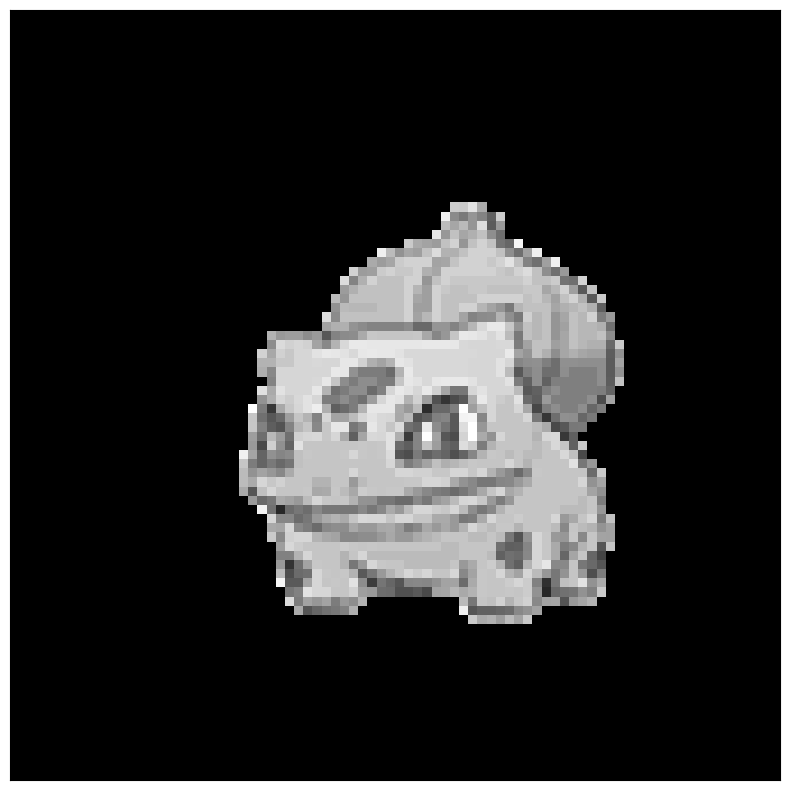

In [37]:
plot_poke(x = pokeimg_data[0, :]) # bulbasaur
#plot_poke(x = pokeimg_data[24, :]) # pikachu (most people's favourite)
#plot_poke(x = pokeimg_data[103, :]) # cubone (my favourite)

In [38]:
def inverse_transform(x_compress, pca, limit_coef=None):
    """ estimates original sample given compressed pca coef
    
    Args:
        x_compress (np.array): the pca coefficients
        pca (PCA): sklearn's pca object
        limit_coef (int): we predict using only the first
            limit_coef coefficients
            
    Returns:
        x_pred (np.array): the estimated image, same shape
            as the original input image
    """
    if limit_coef is None:
        # default to all components
        limit_coef = pca.n_components_
    
    # initialize prediction to mean
    x_pred = pca.mean_
        
    # add pca directions one by one
    for coef_idx in range(limit_coef):
        coef = x_compress[coef_idx]
        comp = pca.components_[coef_idx, :]
        x_pred += coef * comp
        
    return x_pred

**Note**: You actually cannot have more principal components than number of observations; thus, in this case with images, the maximum number of components is in the number of images we have.

This means by performing PCA with this data set, we have already compressed the data so that it takes up only $809/7056 \approx .115$, or 11.5% of the original memory. Can we do even better?

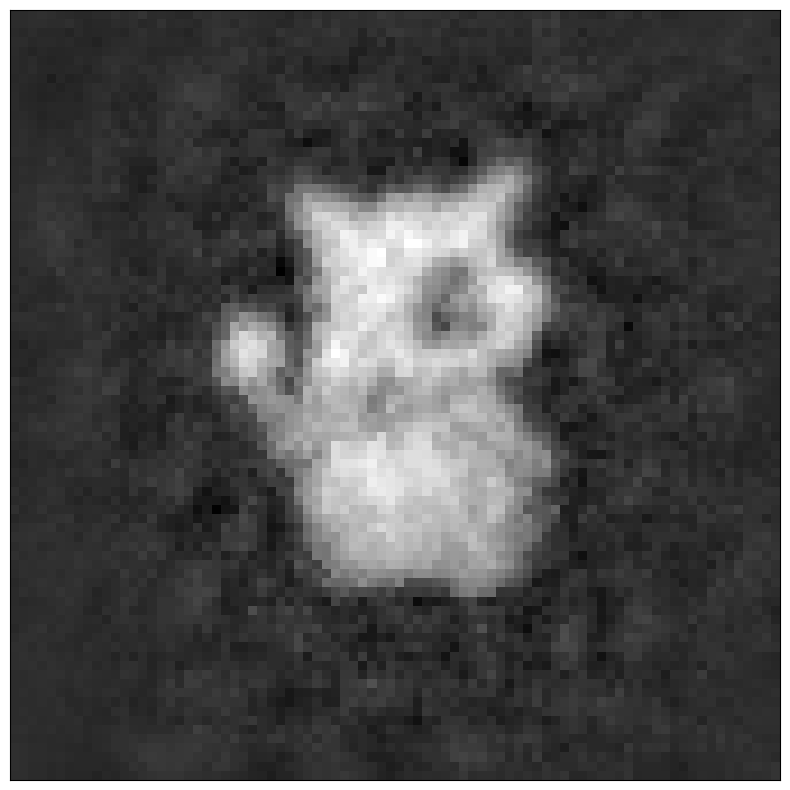

In [39]:
# the default n_components will have PCA build as 
# many components as there are min(obs, feat).  this is preferred
# here as we can use our limit_coef param as needed
pca = PCA()

# compress all pokemon to lower dimensional representation
pokeimg_data_compress = pca.fit_transform(pokeimg_data)

# extract a particular pokemon
sample_idx = 103
x_compress = pokeimg_data_compress[sample_idx, :]

# plot it for a given number of PCs
x_pred = inverse_transform(x_compress, pca, limit_coef=200)
plot_poke(x_pred)

In [40]:
def whos_that_pokemon(sample_idx, x, start_coef=0, end_coef=10, jump_coef=None):
    """ plots estimates of original image from pca compression
    
    Args:
        sample_idx (int): which image to work with
        x (np.array): (n_sample, n_feat) original image data
        start_coef (int): minimum pca coefficient to represent
        end_coef (int): maximum pca coefficient to represent
        jump_coef (list): a list/range of numbers for which pca coefficients to represent
    """
    
    
    # the default n_components will have PCA build as 
    # many components as there are min(obs, feat).  this is preferred
    # here as we can use our limit_coef param as needed
    pca = PCA()

    # compress all pokemon to lower dimensional representation
    pokeimg_data_compress = pca.fit_transform(pokeimg_data)
    
    if jump_coef==None:
        whichplots = range(start_coef, end_coef)
    else:
        whichplots = jump_coef
    
    for limit_coef in whichplots:
        # estimate original image
        x_compress = pokeimg_data_compress[sample_idx, :]
        x_pred = inverse_transform(x_compress, pca, limit_coef=limit_coef)
        
        # compute compression ratio stats
        n_compress = limit_coef + 1
        n = x_pred.size
        p = n_compress / n
        
        # plot this estimate
        plt.figure()
        plot_poke(x_pred)
        title = f'{n_compress} of {n} features ({p:.3f} of memory)'
        plt.suptitle(title)

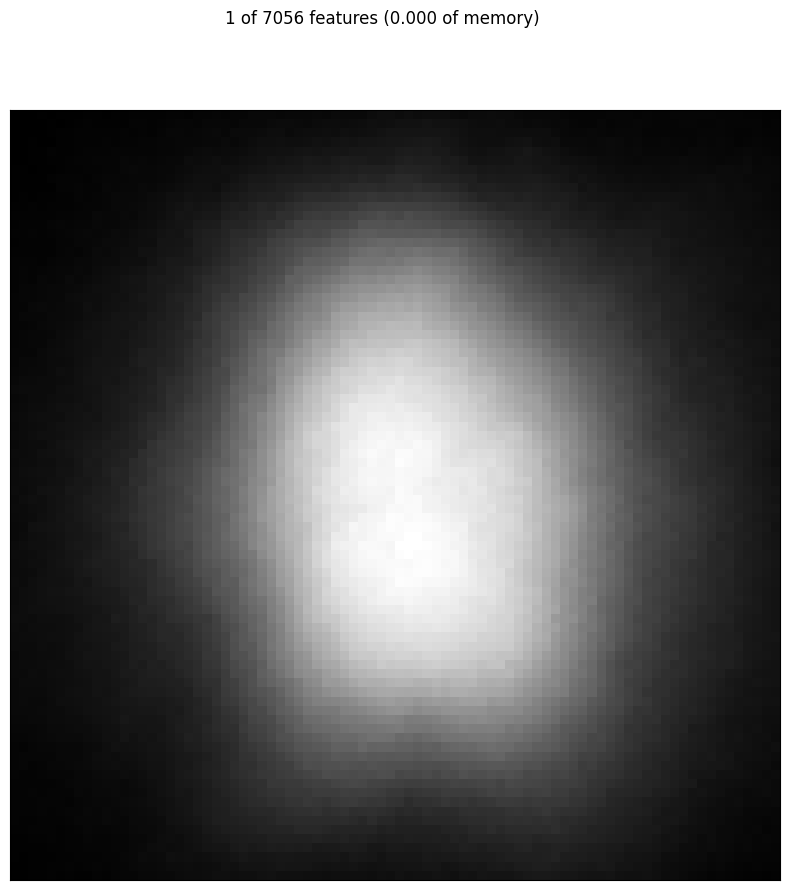

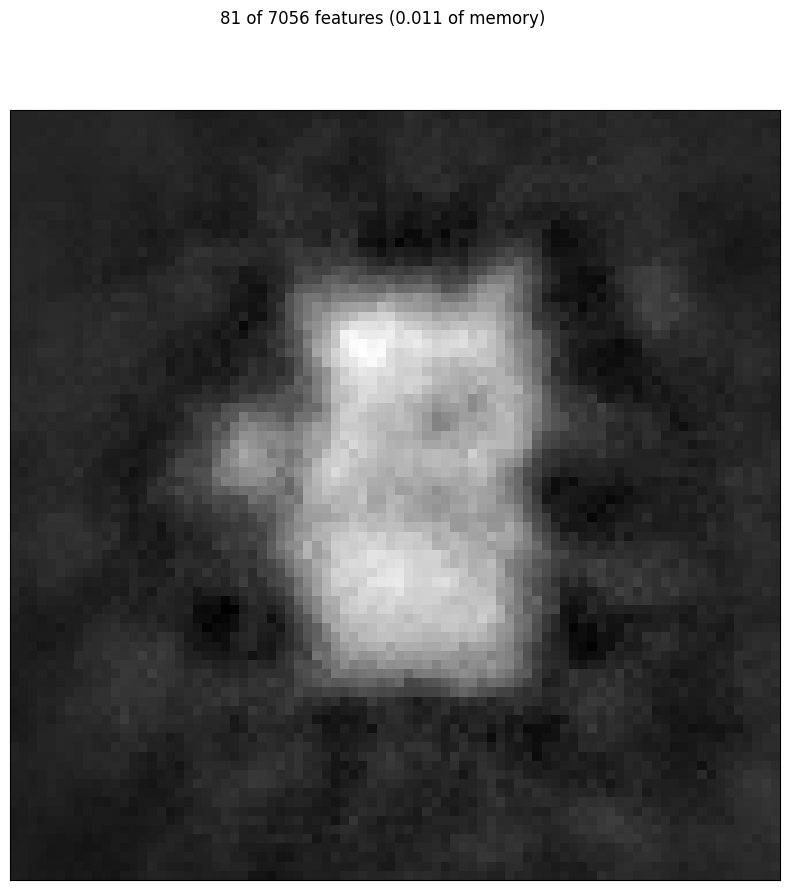

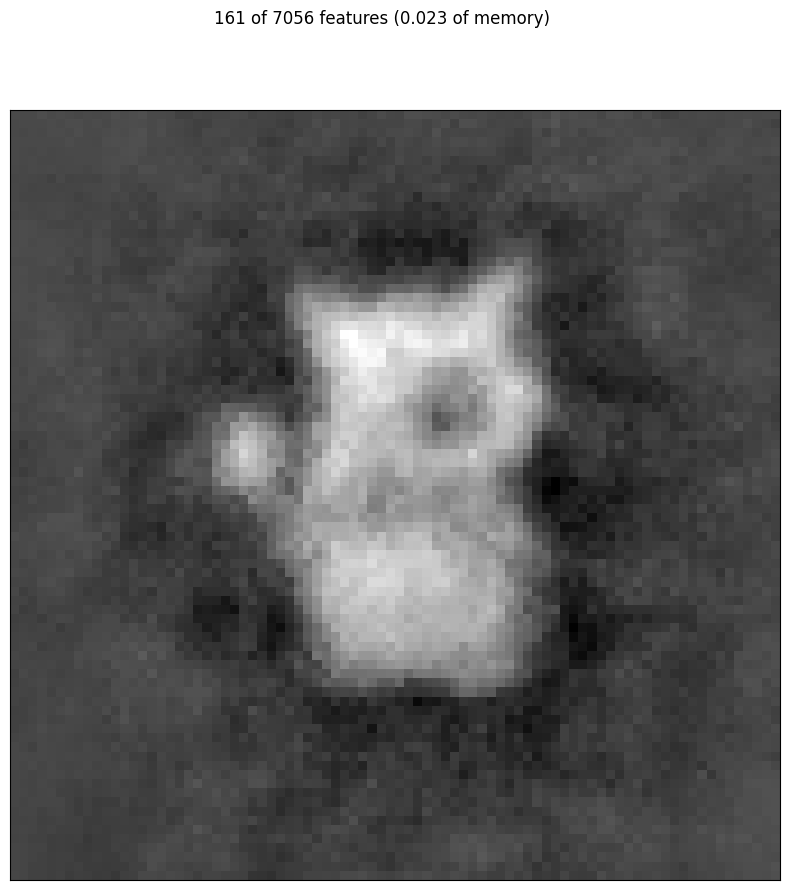

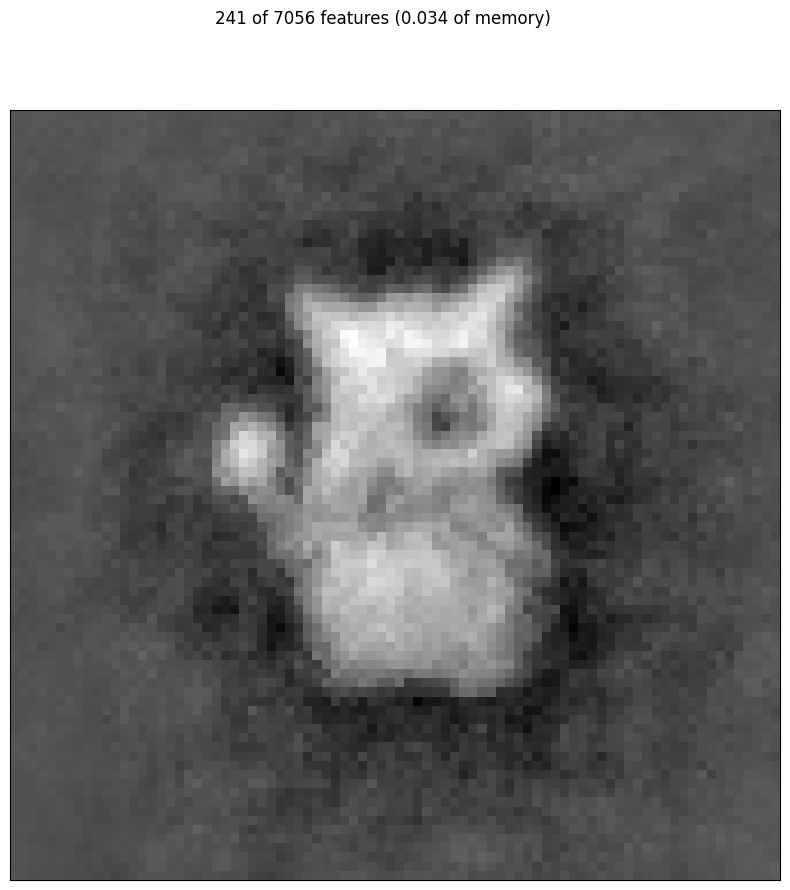

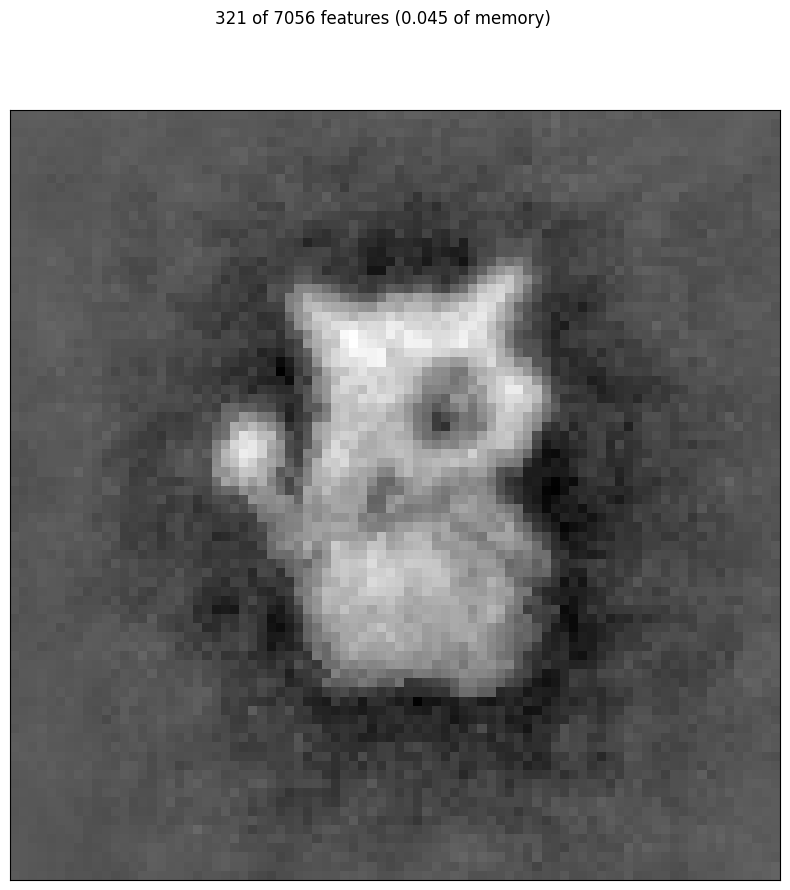

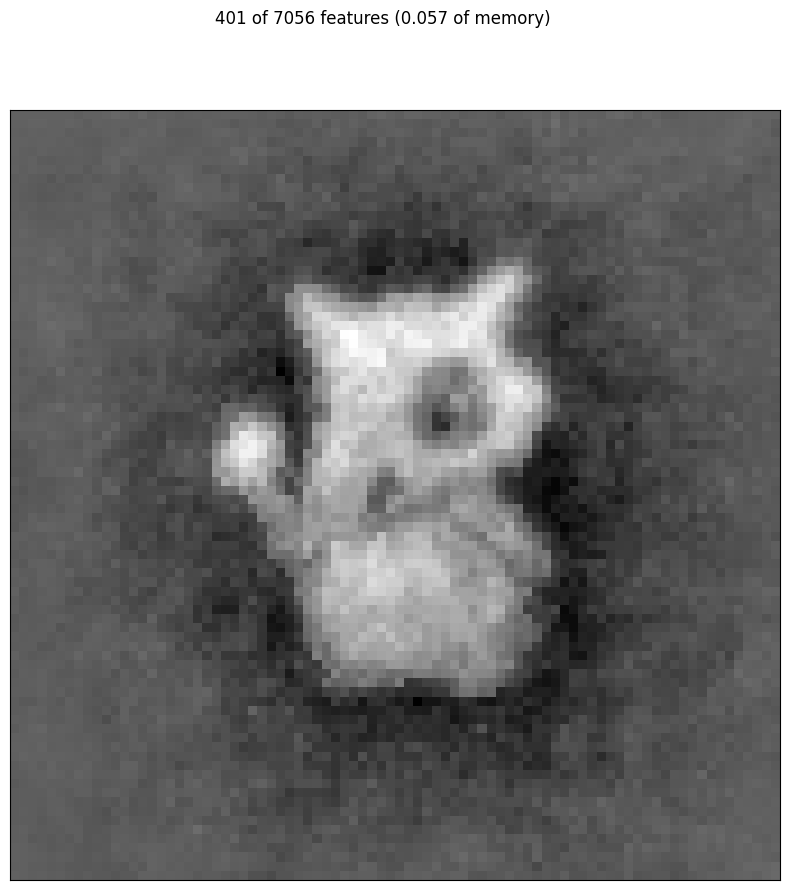

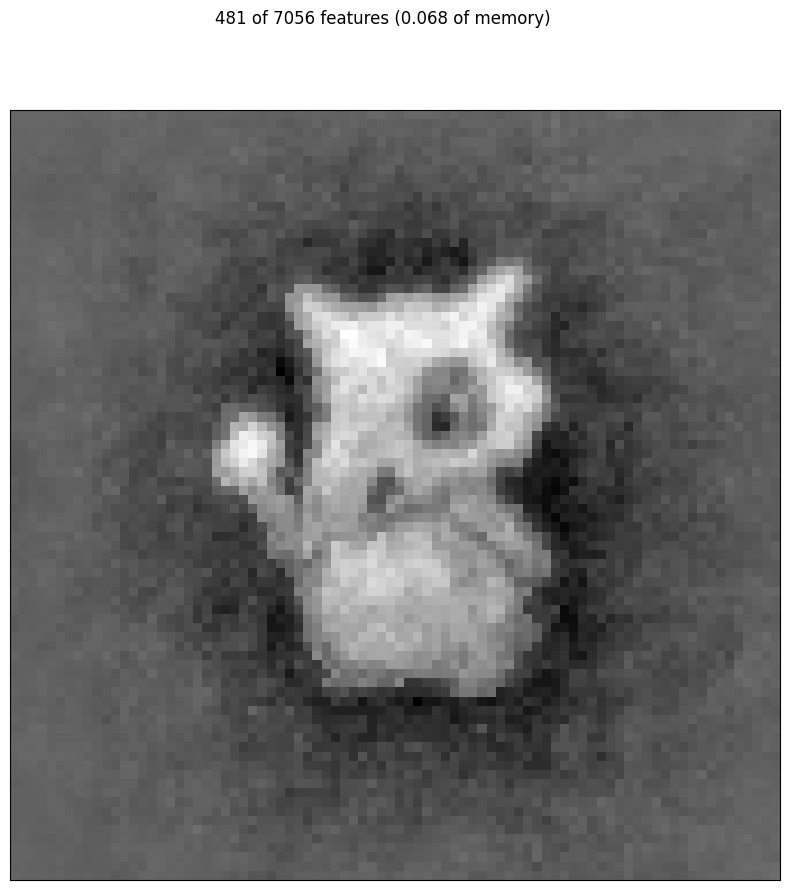

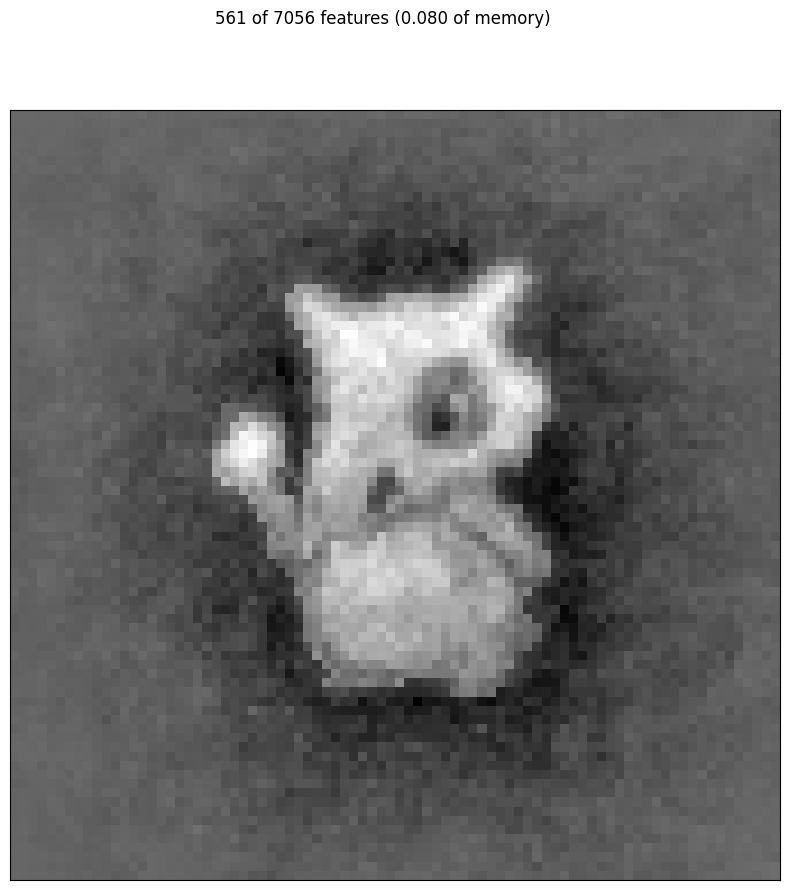

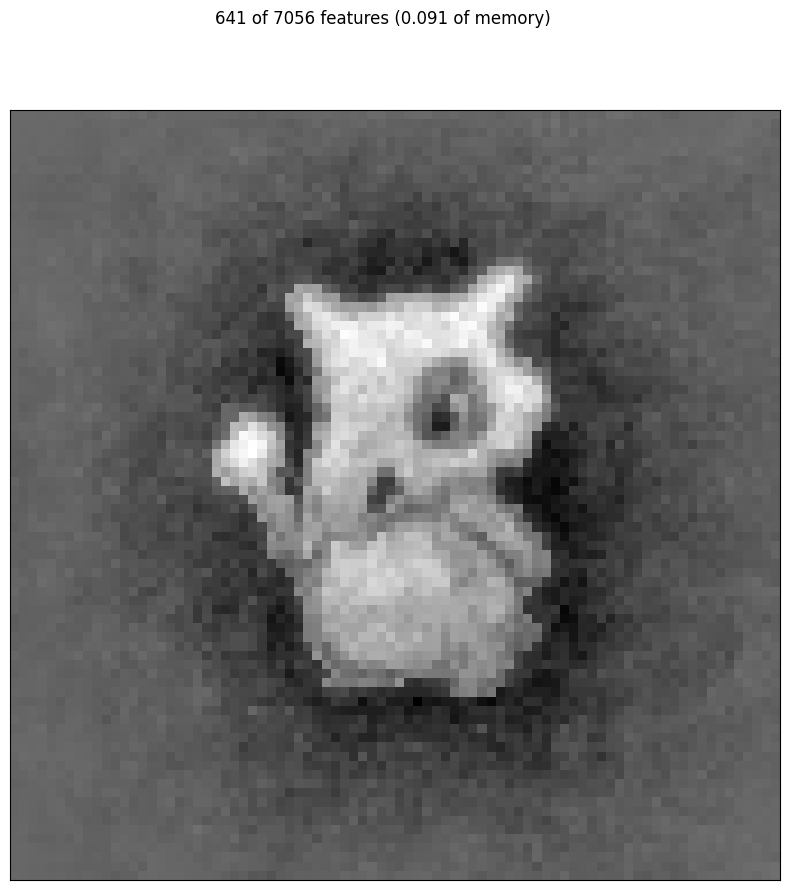

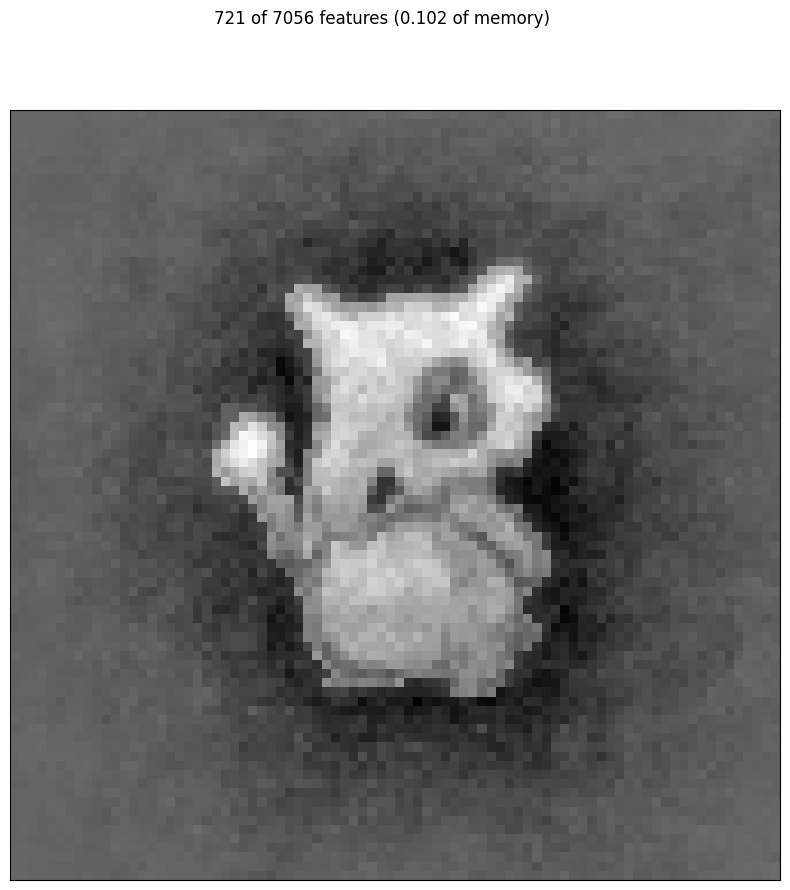

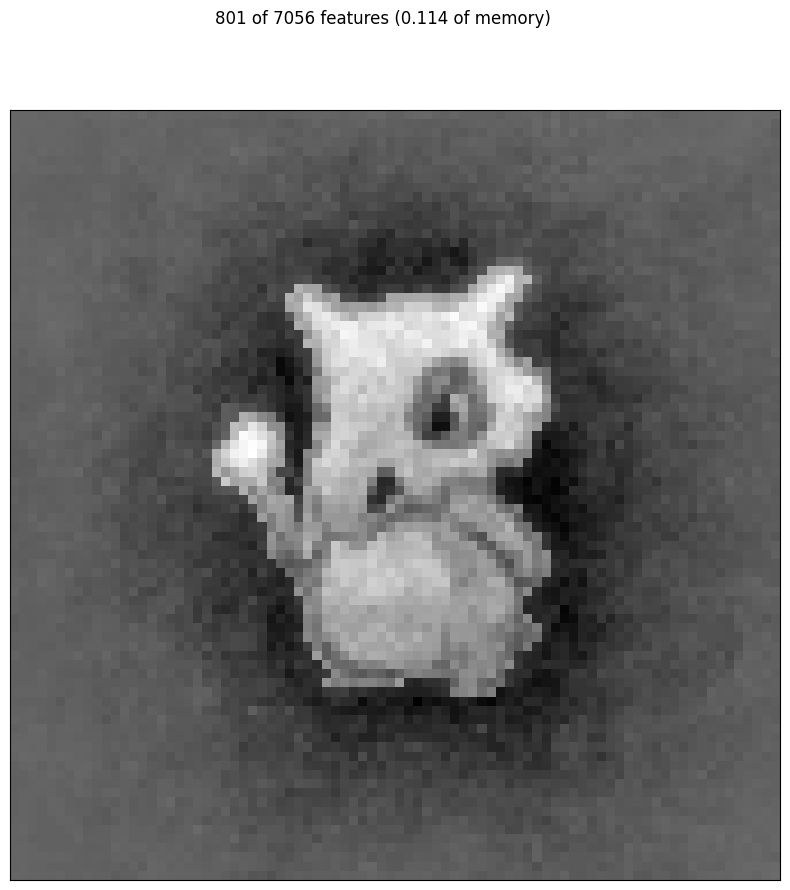

In [41]:
whos_that_pokemon(sample_idx=103, x=pokeimg_data, jump_coef=range(0, 809, 80))